In [ ]:
# Clone the entire repo.
!git clone --branch tf2 --single-branch  -l -s https://github.com/cimat-ris/OF-PathPred.git clonedrep

# Change directory into cloned repository
%cd clonedrep/evaluation_opticalflow

In [17]:
# Imports
import sys,os
''' TF_CPP_MIN_LOG_LEVEL
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printed
3 = INFO, WARNING, and ERROR messages are not printed
'''
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append('lib/')
import math,numpy as np
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
print('[INF] Tensorflow version: ',tf.__version__)
tf.test.gpu_device_name()
# Important imports
import batches_data
from training_and_testing import Experiment_Parameters
import matplotlib.pyplot as plt
from model import TrajectoryEncoderDecoder, Model_Parameters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from datasets_utils import setup_loo_experiment, get_testing_batch
from plot_utils import plot_training_data,plot_training_results
from testing_utils import evaluation_minadefde,plot_comparisons_minadefde

[INF] Tensorflow version:  2.4.0


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices)>0:
    print('[INF] Using GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("[INF] Using CPU")

[INF] Using CPU


In [6]:
# Load the default parameters
experiment_parameters = Experiment_Parameters(add_social=False,add_kp=False,obstacles=False)

dataset_dir   = "../datasets/"
dataset_names = ['eth-hotel','eth-univ','ucy-zara01','ucy-zara02','ucy-univ']

In [7]:
# Load the dataset and perform the split
idTest = 2
training_data,validation_data,test_data,test_homography = setup_loo_experiment('ETH_UCY',dataset_dir,dataset_names,idTest,experiment_parameters,use_pickled_data=False)


[INF] Testing/validation dataset: ['ucy-zara01']
[INF] Training datasets: ['eth-hotel', 'eth-univ', 'ucy-zara02', 'ucy-univ']
[INF] Extracting data from the datasets
[INF] Sequence length (observation+prediction): 20
[INF] Reading ../datasets/ucy-zara01/mundo/mun_pos.csv
[INF] Total number of frames:  872
[INF] Total number of sample sequences:  2356
[INF] Sequence length (observation+prediction): 20
[INF] Reading ../datasets/eth-hotel/mundo/mun_pos.csv
[INF] Total number of frames:  1168
[INF] Reading ../datasets/eth-univ/mundo/mun_pos.csv
[INF] Total number of frames:  876
[INF] Reading ../datasets/ucy-zara02/mundo/mun_pos.csv
[INF] Total number of frames:  1052
[INF] Reading ../datasets/ucy-univ/mundo/mun_pos.csv
[INF] Total number of frames:  541
[INF] Total number of sample sequences:  17201
[INF] Training data: 15481
[INF] Test data: 2356
[INF] Validation data: 1720


In [8]:
#############################################################
# Model parameters
model_parameters = Model_Parameters(add_attention=True,add_kp=experiment_parameters.add_kp,add_social=experiment_parameters.add_social,output_representation=experiment_parameters.output_representation)
if experiment_parameters.output_representation == 'vw':
    model_parameters.num_epochs = 100
    model_parameters.initial_lr = 0.1
model_parameters.num_epochs     = 35
model_parameters.output_var_dirs= 4
model_parameters.is_mc_dropout  = True
model_parameters.initial_lr     = 0.03

# Running on CPU
if len(physical_devices)==0:
    model_parameters.batch_size     = 64
    model_parameters.output_var_dirs= 1
    model_parameters.stack_rnn_size = 1


In [9]:
# Get the necessary data
train_data = tf.data.Dataset.from_tensor_slices(training_data)
val_data   = tf.data.Dataset.from_tensor_slices(validation_data)
test_data  = tf.data.Dataset.from_tensor_slices(test_data)


In [10]:
# Form batches
batched_train_data = train_data.batch(model_parameters.batch_size)
batched_val_data   = val_data.batch(model_parameters.batch_size)
batched_test_data  = test_data.batch(model_parameters.batch_size)


In [11]:
# Model
tj_enc_dec = TrajectoryEncoderDecoder(model_parameters)


Model: "trajectory_and_context_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
observed_trajectory (InputLa [(None, 8, 2)]            0         
_________________________________________________________________
trajectory_encoder (Trajecto [(None, 8, 256), [(None,  394624    
_________________________________________________________________
tf.stack (TFOpLambda)        (None, 1, 8, 256)         0         
Total params: 394,624
Trainable params: 394,624
Non-trainable params: 0
_________________________________________________________________
Model: "observed_trajectory_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
observed_trajectory_h (Input [(None, 256)]             0         
_________________________________________________________________
observed_dense (Dense)       (None, 64)                1

In [12]:
# Checkpoints
checkpoint_dir   = './training_checkpoints'
checkpoint_prefix= os.path.join(checkpoint_dir, "ckpt")
checkpoint       = tf.train.Checkpoint(optimizer=tj_enc_dec.optimizer,
                                        encoder=tj_enc_dec.enc,
                                        decoder=tj_enc_dec.dec,
                                        enctodec=tj_enc_dec.enctodec,
                                        obs_classif=tj_enc_dec.obs_classif)


In [13]:
# Training
perform_training = False
plot_training    = True
if perform_training==True:
    print("[INF] Training the model")
    train_loss_results,val_loss_results,val_metrics_results,__ = tj_enc_dec.training_loop(batched_train_data,batched_val_data,model_parameters,checkpoint,checkpoint_prefix)
    if plot_training==True:
        plot_training_results(train_loss_results,val_loss_results,val_metrics_results)


In [18]:
# Testing
# Restoring the latest checkpoint in checkpoint_dir
print("[INF] Restoring last model")
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


[INF] Restoring last model


  0%|          | 0/37 [00:00<?, ?it/s]

[INF] Quantitative testing


100%|##########| 37/37 [00:26<00:00,  1.37it/s]


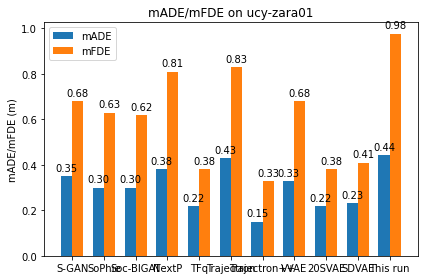

{'mADE': 0.4422266, 'mFDE': 0.97740126}


In [19]:
# Quantitative testing: ADE/FDE
print("[INF] Quantitative testing")
results = evaluation_minadefde(tj_enc_dec,batched_test_data,model_parameters)
plot_comparisons_minadefde(results,dataset_names[idTest])
print(results)


[INF] Qualitative testing
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)


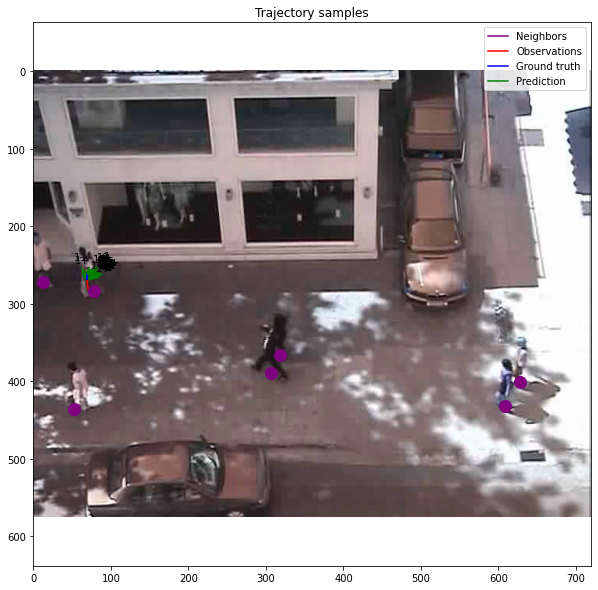

(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)
(3, 12, 2)


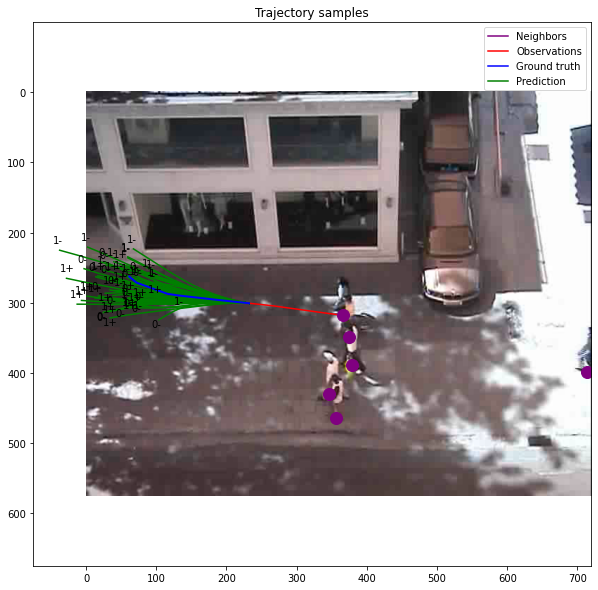

In [ ]:
# Qualitative testing
qualitative = True
if qualitative==True:
    print("[INF] Qualitative testing")
    for i in range(10):
        batch, test_bckgd = get_testing_batch(test_data,dataset_dir+dataset_names[idTest])
        tj_enc_dec.qualitative_evaluation(batch,model_parameters,background=test_bckgd,homography=test_homography, flip=False,n_peds_max=1,display_mode=None)
